In [1]:
import pegasos
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import pdb
import random
from tqdm import tqdm
from time import time
from sklearn import linear_model


# Keras imports
import keras
from keras.models import load_model, Sequential, Model
from keras.layers import Dropout, Dense, Conv2D, Flatten, MaxPooling2D, Activation, Input, LeakyReLU, BatchNormalization
from keras.callbacks import ModelCheckpoint


def plot_pr(y_test, y_gt):
    average_precision = average_precision_score(y_test, y_gt)
    precision, recall, _ = precision_recall_curve(y_test, y_gt)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.5, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve: AUC={0:0.2f}'.format(
              average_precision))
    plt.show()
    
class SVM_Triplet:
    def __init__(self, X1, X2, Y, base_classes, pos_class, new_class):
        self.X1 = X1
        self.X2 = X2
        self.Y = Y
        self.base_classes = base_classes
        self.pos_class = pos_class
        self.new_class = new_class

def prepare_features(pos_class, neg_classes, feature_vectors, is_train=True, 
                     equal_features=False, train_split=0.9):
    '''
    Returns 4096-dim features for each image which would be used for SVM training
    inputs : 
        is_train -> will return 90% of features for each class if is_train=True, else returns 10% features
        equal_features -> if set to True, then len(neg_features) = len(pos_features)
    
    Returns:
        pos_features -> features of images in the positive class
        neg_features -> features of images in the negative classes
    '''
    
    pos_partition = int(train_split*feature_vectors[pos_class].shape[0])
    neg_features = []
    if is_train:
        pos_features = feature_vectors[pos_class][:pos_partition]    # n x 4096
        for neg_class in neg_classes:
            neg_partition = int(train_split*feature_vectors[neg_class].shape[0])
            neg_features.extend(feature_vectors[neg_class][:neg_partition])
            
    else:
        pos_features = feature_vectors[pos_class][pos_partition:]    # n x 4096
        for neg_class in neg_classes:
            neg_partition = int(train_split*feature_vectors[neg_class].shape[0])
            neg_features.extend(feature_vectors[neg_class][neg_partition:])
             
    if equal_features:
        neg_features = np.random.permutation(neg_features)[:pos_features.shape[0]]
    
    return pos_features, neg_features
    
def compute_accuracy(weight_vector, pos_features, neg_features):
    classifier = pegasos.PegasosSVMClassifier()
    classifier.fit(np.zeros((2, 1024)), np.asarray([1, 0]))
    classifier.weight_vector.weights = weight_vector

    # Concat data and pass to SVM
    result = classifier.predict(np.vstack((pos_features, neg_features)))
    ground_truth = np.concatenate((np.ones(len(pos_features)), np.zeros(len(neg_features))))
    return np.average(np.equal(ground_truth, result)), result, ground_truth

def get_svm_weights(x_train, y_train, sklearn_SGD=False):
    if sklearn_SGD:
        clf = linear_model.SGDClassifier()
        clf.partial_fit(x_train, y_train, classes=np.unique(y_train))
        weights = clf.coef_
        return clf
    else:
        svm = pegasos.PegasosSVMClassifier()
        svm.fit(x_train, y_train)
        weight_vector = svm.weight_vector.weights
        return weight_vector


def get_x_y(pos_features, neg_features):
    x = np.vstack((pos_features, neg_features))
    y = np.hstack((np.ones( len(pos_features)),
                   np.zeros(len(neg_features))))
    return x, y


'''
We only need the negative features for the novel class. 
(It is negative with respect to the positive class)
'''
def online_svm_update(clf, neg_features):
    clf.partial_fit(neg_features, np.zeros(len(neg_features)))
    return clf
    

'''
SVM for novel class. 
pos_class = pos_class
neg_classes = base_classes - pos_class
'''
def compute_X1(pos_class, base_classes, feature_vectors, is_train=True, sklearn_SGD=False):
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    pos_features, neg_features = prepare_features(pos_class, neg_classes, feature_vectors, is_train=is_train)
    x_train, y_train = get_x_y(pos_features, neg_features)
    return get_svm_weights(x_train, y_train, sklearn_SGD=sklearn_SGD)
    


'''
SVM for novel class. 
pos_class = novel_class
neg_classes = base_classes
'''
def compute_X2(novel_class, base_classes, feature_vectors, is_train=True, sklearn_SGD=False):
    pos_features, neg_features = prepare_features(novel_class, base_classes, feature_vectors, is_train=is_train)
    x_train, y_train = get_x_y(pos_features, neg_features)
    return get_svm_weights(x_train, y_train, sklearn_SGD=sklearn_SGD)
    
'''
SVM for pos class under the influence of the neg class. 
pos_class = pos_class
neg_classes = base_classes - pos_class + novel_class
'''
def compute_Y(pos_class, novel_class, base_classes, feature_vectors, is_train=True, sklearn_SGD=False):
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    neg_classes = np.append(neg_classes, novel_class)
    pos_features, neg_features = prepare_features(pos_class, neg_classes, feature_vectors, is_train=is_train)
    x_train, y_train = get_x_y(pos_features, neg_features)
    return get_svm_weights(x_train, y_train, sklearn_SGD=sklearn_SGD)

Using TensorFlow backend.


In [2]:
FEATURE_FILE = '/media/red/capstone/data/stanford_40/vgg16_features.pkl'
TRIPLETS_FILE = '/media/red/capstone/data/stanford_triplets_sklearn_500k.pkl'
TRIPLETS_FILE_2 = '/media/red/capstone/data/stanford_triplets_sklearn_plus2.pkl'


features, file_names = pickle.load(open(FEATURE_FILE, "rb"))

seed = 1234
random.seed(seed)
np.random.seed(seed)

# Splitting classes into train/val/test
labels = np.array(list(features.keys()))
perm = np.random.permutation(len(labels))
labels = labels[perm]

splits = {}
splits['base']=labels[:15]
splits['novel'] = labels[15:25]
splits['test']=labels[25:]

print(splits)

{'base': array(['phoning', 'rowing_a_boat', 'cutting_vegetables', 'waving_hands',
       'riding_a_bike', 'writing_on_a_board', 'running', 'throwing_frisby',
       'taking_photos', 'jumping', 'looking_through_a_microscope',
       'playing_guitar', 'looking_through_a_telescope', 'fixing_a_car',
       'gardening'],
      dtype='<U28'), 'novel': array(['holding_an_umbrella', 'walking_the_dog', 'playing_violin',
       'pushing_a_cart', 'riding_a_horse', 'smoking', 'fixing_a_bike',
       'writing_on_a_book', 'texting_message', 'feeding_a_horse'],
      dtype='<U28'), 'test': array(['cleaning_the_floor', 'brushing_teeth', 'cutting_trees', 'cooking',
       'climbing', 'reading', 'drinking', 'washing_dishes',
       'shooting_an_arrow', 'watching_TV', 'using_a_computer',
       'blowing_bubbles', 'pouring_liquid', 'fishing', 'applauding'],
      dtype='<U28')}


## Online SVM Baseline (10 + 1)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/animesh/anaconda3/envs/capstone/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
100%|██████████| 1000/1000 [01:44<00:00,  9.41it/s]


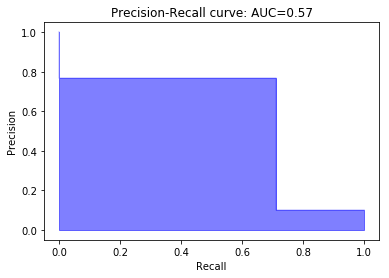

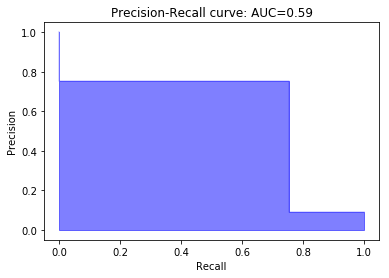

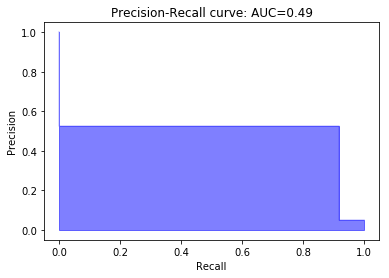

In [3]:
# For PR curves
X1_preds=[]
gts = []
Y_preds = []
Y_online_preds = []


for i in tqdm(range(1000)):
    
    base_class_ind = np.random.permutation(len(splits['base']))[:10]
    base_classes = splits['base'][base_class_ind]
    pos_class = np.random.choice(base_classes)
    novel_class = np.random.choice(splits['test'])
    
    # SVM weights of pos class
    clf_X1 = compute_X1(pos_class, base_classes, features, is_train=True, sklearn_SGD=True)
    X1 = clf_X1.coef_
    
    # SVM weights of novel class
    clf_X2 = compute_X2(novel_class, base_classes, features, is_train=True, sklearn_SGD=True)
    X2 = clf_X2.coef_
    
    # SVM weights of pos class under the influence of novel class
    clf_Y = compute_Y(pos_class, novel_class, base_classes, features, is_train=True, sklearn_SGD=True)
    Y = clf_Y.coef_

    
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    neg_classes_extra = np.append(neg_classes, novel_class)    # 9 + 1 classes
    pos_features_test, neg_features_test = prepare_features(pos_class, 
                                                            neg_classes_extra, 
                                                            features, 
                                                            is_train=False, 
                                                            equal_features=False)
    gt = np.concatenate((np.ones(len(pos_features_test)), np.zeros(len(neg_features_test))))
    
    # Mean accuracies
    to_predict = np.vstack((pos_features_test, neg_features_test))
#     acc1 = clf_X1.score(to_predict, gt)
#     acc2 = clf_Y.score(to_predict, gt)
                           
    # Need the predictions for PR curves
    X1_pred = clf_X1.predict(to_predict)
    Y_pred = clf_Y.predict(to_predict)
                           
    # Online SVM update
    neg_partition = int(0.9*features[novel_class].shape[0])
    neg_features = features[novel_class][:neg_partition]
    clf_Y_online = online_svm_update(clf_X1, neg_features)
    Y_online = clf_Y_online.coef_
#     acc3 = clf_Y_online.score(to_predict, gt)  
    Y_pred_online = clf_Y_online.predict(to_predict)
    
#     print('%.5f %.5f %.5f' % (acc1,acc2, acc3))                       

    # PR curve stuff
    X1_preds.extend(X1_pred.tolist())
    Y_preds.extend(Y_pred.tolist())
    Y_online_preds.extend(Y_pred_online.tolist())
    gts.extend(gt.tolist())
    
plot_pr(X1_preds, gts)
plot_pr(Y_preds, gts)
plot_pr(Y_online_preds, gts)
    

## Online SVM (10 + 2)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/animesh/anaconda3/envs/capstone/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
100%|██████████| 1000/1000 [01:17<00:00, 12.59it/s]


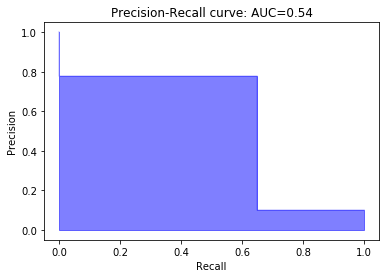

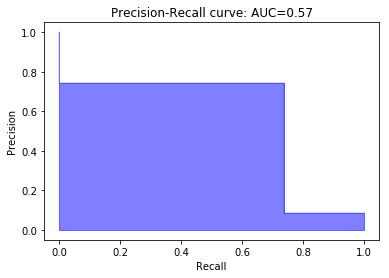

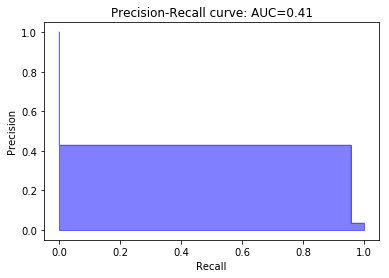

In [4]:
# For PR curves
X1_preds=[]
gts = []
Y_preds = []
Y_online_preds = []

for i in tqdm(range(1000)):
    
    base_class_ind = np.random.permutation(len(splits['base']))[:10]
    base_classes = splits['base'][base_class_ind]
    pos_class = np.random.choice(base_classes)
    novel_class_1 = np.random.choice(splits['test'])
    novel_class_2 = np.random.choice(np.delete(splits['test'], np.argwhere(splits['test']==novel_class_1)))
    
    # SVM weights of pos class
    clf_X1 = compute_X1(pos_class, base_classes, features, is_train=True, sklearn_SGD=True)
    
    # SVM weights of pos class under the influence of novel class
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    neg_classes = np.append(neg_classes, novel_class_1)
    neg_classes = np.append(neg_classes, novel_class_2)
    
    pos_features_train, neg_features_train = prepare_features(pos_class, neg_classes, features, is_train=True)
    x_train, y_train = get_x_y(pos_features_train, neg_features_train)
    clf_Y = get_svm_weights(x_train, y_train, sklearn_SGD=True)
    
    
    pos_features_test, neg_features_test = prepare_features(pos_class, 
                                                            neg_classes, 
                                                            features, 
                                                            is_train=False, 
                                                            equal_features=False)
    gt = np.concatenate((np.ones(len(pos_features_test)), np.zeros(len(neg_features_test))))
    
    to_predict = np.vstack((pos_features_test, neg_features_test))
    
                           
    # Need the predictions for PR curves
    X1_pred = clf_X1.predict(to_predict)
    Y_pred = clf_Y.predict(to_predict)
                           
    # Online SVM update
    # First for novel class 1
    neg_partition = int(0.9*features[novel_class_1].shape[0])
    neg_features = features[novel_class_1][:neg_partition]
    clf_Y_online = online_svm_update(clf_X1, neg_features)
    
    # Now for novel class 2
    neg_partition = int(0.9*features[novel_class_2].shape[0])
    neg_features = features[novel_class_2][:neg_partition]
    clf_Y_online = online_svm_update(clf_Y_online, neg_features) 
    Y_pred_online = clf_Y_online.predict(to_predict)
                        

    # PR curve stuff
    X1_preds.extend(X1_pred.tolist())
    Y_preds.extend(Y_pred.tolist())
    Y_online_preds.extend(Y_pred_online.tolist())
    gts.extend(gt.tolist())
    
plot_pr(X1_preds, gts)
plot_pr(Y_preds, gts)
plot_pr(Y_online_preds, gts)

### Create triplets for training

In [7]:
temp = pickle.load(open(TRIPLETS_FILE_2, "rb"))
print(temp)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [8]:
print(len(temp))

100000


In [5]:
NUM_SIMULATIONS = 200
triplets = []
triplets_prev = pickle.load(open(TRIPLETS_FILE, "rb"))
triplets_prev = triplets_prev[:100000]

In [6]:
for i, triplet in tqdm(enumerate(triplets_prev)):
    
    base_classes = triplet.base_classes
    pos_class = triplet.pos_class
    novel_class1 = triplet.new_class
    novel_class2 = np.random.choice(np.delete(splits['novel'],np.argwhere(splits['novel']==novel_class1)))
    base_classes = np.append(base_classes, novel_class1)
    X1 = triplet.Y
    X2 = compute_X2(novel_class2, base_classes, features, is_train=True, sklearn_SGD=True)
    Y = compute_Y(pos_class, novel_class2, base_classes, features, is_train=True, sklearn_SGD=True)
                                    
    triplets.append(SVM_Triplet(X1, X2.coef_, Y.coef_, base_classes, pos_class, novel_class2))
    
    # Sanity check
                                    
#     neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
#     neg_classes_extra = np.append(neg_classes, new_class)
#     pos_features_test, neg_features_test = prepare_features(pos_class, 
#                                                             neg_classes_extra, 
#                                                             features, 
#                                                             is_train=False, 
#                                                             equal_features=False)

#     to_predict = np.vstack((pos_features_test, neg_features_test))
#     gt = np.concatenate((np.ones(len(pos_features_test)), np.zeros(len(neg_features_test))))

# #     acc1 = X1.score(to_predict, gt) 
#     acc2 = Y.score(to_predict, gt) 

#     if i % 10000 == 0:
#         with open(TRIPLETS_FILE_2, 'wb') as f:
#             pickle.dump(triplets, f)
            
            
with open(TRIPLETS_FILE_2, 'wb') as f:
    pickle.dump(triplets, f)


0it [00:00, ?it/s]/home/animesh/anaconda3/envs/capstone/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
100000it [2:03:24, 13.75it/s]


## Create 11+1 triplets for ground truth

In [ ]:
NUM_SIMULATIONS = 100000
triplets = []

for i in tqdm(range(int(NUM_SIMULATIONS/100))):
    base_class_ind = np.random.permutation(len(splits['base']))[:11]
    base_classes = splits['base'][base_class_ind]
    
    X1s = {}
    for pos_class in base_classes:
        X1s[pos_class] = compute_X1(pos_class, base_classes, features, is_train=True, sklearn_SGD=True)
    
    X2s = {}
    for novel_class in splits['novel']:
        X2s[novel_class] = compute_X2(novel_class, base_classes, features, is_train=True, sklearn_SGD=True)

    
    # The following code generates 100 triplets - 10 pos classes x 10 novel classes for each pos class
    for pos_class in base_classes:
        X1 = X1s[pos_class]
        for new_class in splits['novel']:
            
            X2 = X2s[novel_class]
            Y = compute_Y(pos_class, novel_class, base_classes, features, is_train=True, sklearn_SGD=True)
            
            # Sanity check
#             t1 = time()
#             neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
#             neg_classes_extra = np.append(neg_classes, new_class)
#             pos_features_test, neg_features_test = prepare_features(pos_class, 
#                                                                     neg_classes_extra, 
#                                                                     features, 
#                                                                     is_train=False, 
#                                                                     equal_features=False)
            
#             to_predict = np.vstack((pos_features_test, neg_features_test))
#             gt = np.concatenate((np.ones(len(pos_features_test)), np.zeros(len(neg_features_test))))
            
#             acc1 = X1.score(to_predict, gt) 
#             acc2 = Y.score(to_predict, gt) 
            # print (time() - t1)
            
#             print(acc1, acc2)
            
            triplets.append(SVM_Triplet(X1.coef_, X2.coef_, Y.coef_, base_classes, pos_class, novel_class))
        
    if i % 100 == 0:
        with open(TRIPLETS_FILE, 'wb') as f:
            pickle.dump(triplets, f)


## Training the regressor network

In [ ]:
# Prepare data for training
triplets = pickle.load(open(TRIPLETS_FILE, "rb"))
triplets = triplets[:200000]

In [ ]:
'''
Prepare data for training
'''
normalize = False
X_train, Y_train = [], []
for triplet in tqdm(triplets):
    
    ### NORMALIZE X1, X2 and Y here!!!
    if normalize:
        X1 = triplet.X1 / np.linalg.norm(triplet.X1, axis=0, keepdims=True)
        X2 = triplet.X2 / np.linalg.norm(triplet.X2, axis=0, keepdims=True)
        Y  = triplet.Y  / np.linalg.norm(triplet.Y,  axis=0, keepdims=True)
        X_train.append(np.hstack((X1, X2)))
        Y_train.append(Y-X1)
    
    else:   
        X_train.append(np.hstack((triplet.X1, triplet.X2)))
        Y_train.append(triplet.Y-triplet.X1)
del triplets    # To clear this 19GB out of memory

In [ ]:
(X_train[0].shape)

In [ ]:
'''
Define the architecture
'''
FEATURE_SHAPE = 4096
inp = Input(shape=(FEATURE_SHAPE * 2,))
x = Dense(FEATURE_SHAPE * 2, name='dense_1', activation='relu')(inp)
# x = Dropout(0.1)(x)
# x = BatchNormalization()(x)
# x = LeakyReLU(alpha=0.1, name='relu_1')(x)
x = Dense(FEATURE_SHAPE * 2, name='dense_2', activation='relu')(x)
# x = Dropout(0.1)(x)
# x = BatchNormalization()(x)
# x = LeakyReLU(alpha=0.1, name='lrelu_2')(x)
x = Dense(FEATURE_SHAPE, name='dense_3', activation='relu')(x)
# x = BatchNormalization()(x)
# x = LeakyReLU(alpha=0.1, name='lrelu_3')(x)
x = Dense(FEATURE_SHAPE, name='dense_4')(x)

model = Model(inputs=inp, outputs=x)

optimizer = keras.optimizers.RMSprop(lr=0.0001)

model.compile(loss='cosine_proximity', optimizer=optimizer, metrics=['accuracy'])

    
SAVE_FILE =  'stanford_rms_cosine_200k__lr4_nobn_nonormalize_{epoch:02d}-{val_acc:.2f}.h5'   
    
checkpoint = ModelCheckpoint(SAVE_FILE, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.fit(np.array(X_train), 
          np.array(Y_train), 
          epochs=50, 
          batch_size=32, 
          shuffle=True, 
          verbose=1,
          callbacks=callbacks_list,
          validation_split=0.03)

# model.save('mit_e100_rms_cosine_100k_nobn.h5')

In [ ]:
# Compare our model with the baseline
model = load_model('mit_rms_cosine_100k__lr4_nobn_normalize_04-0.15.h5')
acc1_all, acc2_all = [], []

base_class_ind = np.random.permutation(len(splits['base']))[:10]
base_classes = splits['base'][base_class_ind]
  

for pos_class in base_classes:
    acc1, acc2 = [], []
    X1 = compute_X1(pos_class, base_classes, features, is_train=True)
    X1_norm = X1 / np.linalg.norm(X1, axis=0, keepdims=True)
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))
    
    for new_class in splits['test']:
        neg_classes_extra = np.append(neg_classes, new_class)    # 9 + 1 classes
        pos_features_test, neg_features_test = prepare_features(pos_class, 
                                                                neg_classes_extra, 
                                                                features, 
                                                                is_train=False, 
                                                                equal_features=False)
        acc1.append(compute_accuracy(X1, pos_features_test, neg_features_test))

        # Test out our incremental hypothesis
        X2 = compute_X2(new_class, base_classes, features, is_train=True)
        X2_norm = X2 / np.linalg.norm(X2, axis=0, keepdims=True)
        X = np.hstack((X1_norm, X2_norm))
        X = np.reshape(X, (1, 8192))
        Y_hat = model.predict(X)
        Y = X1 + Y_hat.reshape((4096))
        acc2.append(compute_accuracy(Y, pos_features_test, neg_features_test))
        print('%.5f %.5f %.5f %s|%s' % (acc1[-1],acc2[-1], acc2[-1] - acc1[-1], pos_class, new_class)) 

    acc1_all.append(acc1)
    acc2_all.append(acc2)
    
    
acc1_all = np.array(acc1_all)
acc2_all = np.array(acc2_all)
acc1_mean = np.mean(acc1_all, axis=0)
acc2_mean = np.mean(acc2_all, axis=0)


In [ ]:
# Plotting
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
N = len(splits['test'])         # Number of classes
ind = np.arange(N)                # the x locations for the groups
width = 0.35                      # the width of the bars

## the bars
rects1 = ax.bar(ind, acc1_mean, width,color='orange')
rects2 = ax.bar(ind+width, acc2_mean, width, color='green')

# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,1)
ax.set_ylabel('Accuracy')
ax.set_title('Comparision when adding a new class (10 + 1)')
xTickMarks = ['Class ' + str(i) for i in range(0,21)]
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=12)

## add a legend
ax.legend( (rects1[0], rects2[0]), ('No update', 'SVM weights updated') )

plt.show()

In [ ]:
acc1, acc2 = [], []

for i in range(200):
    base_class_ind = np.random.permutation(len(splits['base']))[:10]
    base_classes = splits['base'][base_class_ind]
    pos_class = np.random.choice(base_classes)
    
    
    X1 = compute_X1(pos_class, base_classes, features, is_train=True)
    neg_classes = np.delete(base_classes, np.argwhere(base_classes==pos_class))


    new_class = np.random.choice(splits['test'])
    neg_classes_extra = np.append(neg_classes, new_class)    # 9 + 1 classes
    pos_features_test, neg_features_test = prepare_features(pos_class, 
                                                            neg_classes_extra, 
                                                            features, 
                                                            is_train=False, 
                                                            equal_features=False)
    

    # Test out our incremental hypothesis
    X2 = compute_X2(new_class, base_classes, features, is_train=True)

    X1_norm = X1 / np.linalg.norm(X1, axis=0, keepdims=True)
    X2_norm = X2 / np.linalg.norm(X2, axis=0, keepdims=True)

    X = np.hstack((X1_norm, X2_norm))
    X = np.reshape(X, (1, 8192))
    Y_hat = model.predict(X)
    Y = X1 + Y_hat.reshape((4096))
    acc1 = compute_accuracy(X1, pos_features_test, neg_features_test)
    acc2 = compute_accuracy(Y, pos_features_test, neg_features_test)
    print('%.5f %.5f %0.3f %s|%s' % (acc1,acc2, acc2-acc1, pos_class, new_class)) 

In [ ]:
print(np.mean(acc1_mean))
print(np.mean(acc2_mean))